In [29]:
# !pip install Tensorflow
# !pip install Keras
# !pip install scikit-learn
# !pip install imblearn
# !pip install scikeras
# !pip install gensim
# !pip install keras-tuner


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import set_random_seed

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
import os
import zipfile
import keras_tuner as kt

In [31]:
set_random_seed(8)

## Importing the data

In [32]:
df = pd.read_csv('data/original_v2_data.csv', index_col =0)
df

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1


In [33]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [34]:
df.dropna(inplace = True)

In [35]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [36]:
df.shape

(28619, 2)

## Splitting data

In [37]:
X = df["headline"]
y = df["is_sarcastic"]

splitting data 70\% train, 10\% validation, 20\% test

In [38]:
#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(X,y, test_size = 0.2, random_state = 8)

#splitting the (training) data into training and validating data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.125, random_state = 8)

In [39]:
X_train.sample(5)

4049                  being moody helps us adapt to change
5126                              bandai recalls lady gaga
870      john legend tries in earnest to talk kanye wes...
18122    want to sleep in 'the world's largest grave'? ...
19098    ayesha curry lands cooking show on the food ne...
Name: headline, dtype: object

In [40]:
y_train.sample(5)

20986    1
24440    1
8150     1
8251     1
15112    1
Name: is_sarcastic, dtype: int64

## Model statistics

In [41]:
def plotCurves(history, model_name):
    results = pd.DataFrame(history.history)
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    ax1.plot(results.index, results.loss)
    ax1.plot(results.index, results.val_loss)
    ax1.set_title(model_name)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Binary Crossentropy Loss")
    ax1.legend(["Training Loss", "Validation Loss"])
   


 
    ax2.plot(results.index, results.accuracy)
    ax2.plot(results.index, results.val_accuracy)
    ax2.set_title(model_name)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(["Training Accuracy", "Validation Accuracy"])
 

    fig.show()

In [42]:


def printModelStats(model, X, y):

    y_pred = model.predict(X)
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1    


    print(classification_report(y, y_pred, target_names = ['Sarcastic', 'Not Sarcastic']))
   
    cm = confusion_matrix(y, y_pred)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

## Tokenizing

In [43]:
tokenizer = Tokenizer(oov_token="<OOV>")

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train)

#choosing max length to be 20, which is is more than 2*STD +- mean number of words per headline
max_length = 20 # max([len(sentence.split()) for sentence in X_train])

X_train_untk = X_train

In [44]:
#tokenizing headlines
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = max_length, padding = "post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = max_length, padding = "post")
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = max_length, padding = "post")

In [45]:
vocab_size = len(tokenizer.word_index)+1
print(f'The size of vocabulary: {vocab_size}')

The size of vocabulary: 25928


## Simple directional GRU

With own embedding

In [46]:
output_dimension = 100

def buildModel1(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [47]:

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [48]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)


In [49]:
# history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


tuner = kt.RandomSearch(buildModel1, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_1')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])


Trial 10 Complete [00h 00m 53s]
val_loss: 0.3329872190952301

Best val_loss So Far: 0.31902286410331726
Total elapsed time: 01h 48m 43s


In [50]:
best_model = tuner.get_best_models()[0]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2592800   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 26267

In [51]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model_1 = tuner.hypermodel.build(best_hp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 262

In [52]:
history = best_model_1.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)


Epoch 1/20
627/627 [==============================] - 20s 27ms/step - loss: 0.5154 - accuracy: 0.7126 - val_loss: 0.3316 - val_accuracy: 0.8532
Epoch 2/20
627/627 [==============================] - 23s 37ms/step - loss: 0.2303 - accuracy: 0.9150 - val_loss: 0.3218 - val_accuracy: 0.8676
Epoch 3/20
627/627 [==============================] - 22s 35ms/step - loss: 0.0970 - accuracy: 0.9670 - val_loss: 0.4008 - val_accuracy: 0.8470
Epoch 4/20
627/627 [==============================] - 17s 27ms/step - loss: 0.0394 - accuracy: 0.9888 - val_loss: 0.5651 - val_accuracy: 0.8480
Epoch 4: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_34452\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


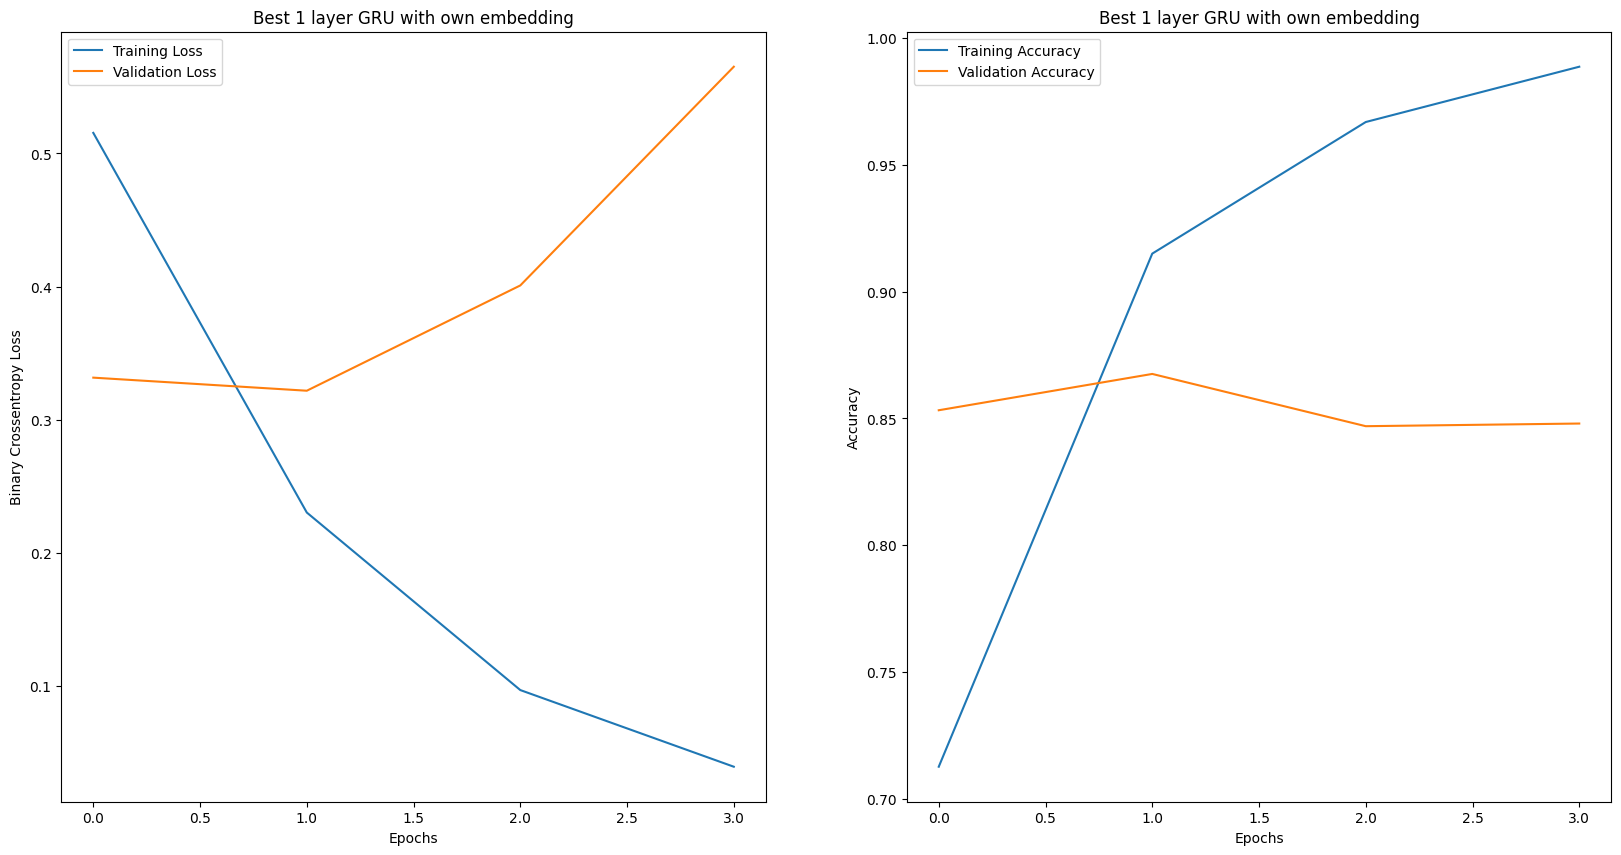

In [53]:
plotCurves(history, "Best 1 layer GRU with own embedding")

printModelStats(model)

90/90 [==============================] - 1s 6ms/step
               precision    recall  f1-score   support

    Sarcastic       0.88      0.85      0.87      1472
Not Sarcastic       0.85      0.88      0.87      1390

     accuracy                           0.87      2862
    macro avg       0.87      0.87      0.87      2862
 weighted avg       0.87      0.87      0.87      2862

The confusion matrix:
[[1258  214]
 [ 165 1225]]


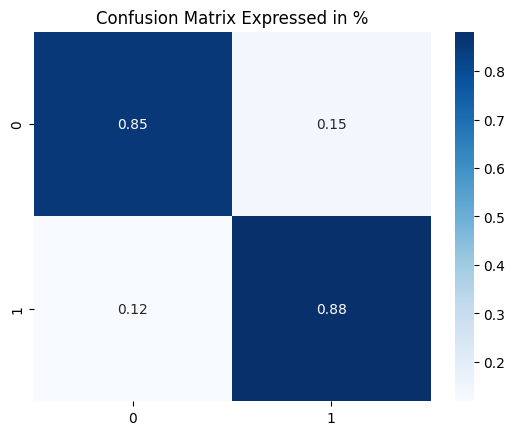

In [54]:
printModelStats(best_model_1, X_val, y_val)

## GRU with Word2Vec Embedding

In [55]:
output_dimension = 100


#Training Word2Vec embedding layer using Skip grams
sentences = [sentence.split() for sentence in X_train_untk]
w2v = Word2Vec(sentences, vector_size = output_dimension, sg=1)

#Creating the embedding weight matrix
embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]



In [56]:


output_dimension = 100
def buildModel2(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [57]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [58]:
tuner = kt.RandomSearch(buildModel2, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_2')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Trial 10 Complete [00h 01m 01s]
val_loss: 0.3118968904018402

Best val_loss So Far: 0.30512985587120056
Total elapsed time: 00h 10m 02s


In [59]:
best_hp2 = tuner.get_best_hyperparameters()[0]
best_model_2 = tuner.hypermodel.build(best_hp2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2626785 (10.02 MB)
Trainable params: 262

In [60]:
history2 = best_model_2.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20


627/627 [==============================] - 19s 26ms/step - loss: 0.4297 - accuracy: 0.7943 - val_loss: 0.3009 - val_accuracy: 0.8697
Epoch 2/20
627/627 [==============================] - 16s 25ms/step - loss: 0.1783 - accuracy: 0.9371 - val_loss: 0.4345 - val_accuracy: 0.8553
Epoch 3/20
627/627 [==============================] - 16s 25ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.4929 - val_accuracy: 0.8515
Epoch 3: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_34452\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


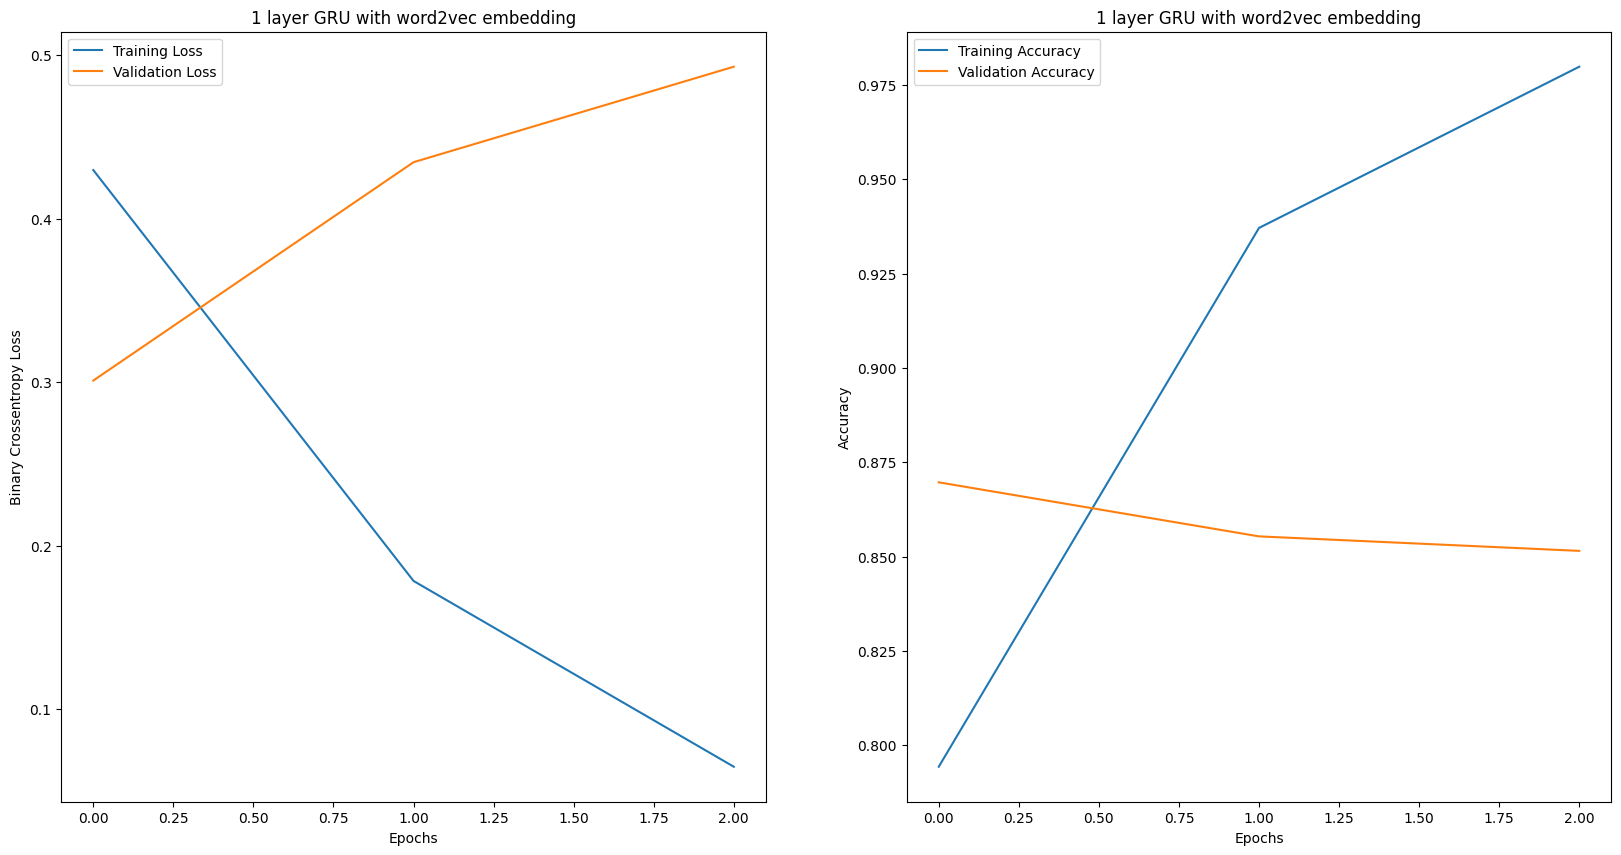

In [61]:
plotCurves(history2, "1 layer GRU with word2vec embedding")

90/90 [==============================] - 1s 3ms/step
               precision    recall  f1-score   support

    Sarcastic       0.89      0.85      0.87      1472
Not Sarcastic       0.85      0.89      0.87      1390

     accuracy                           0.87      2862
    macro avg       0.87      0.87      0.87      2862
 weighted avg       0.87      0.87      0.87      2862

The confusion matrix:
[[1248  224]
 [ 149 1241]]


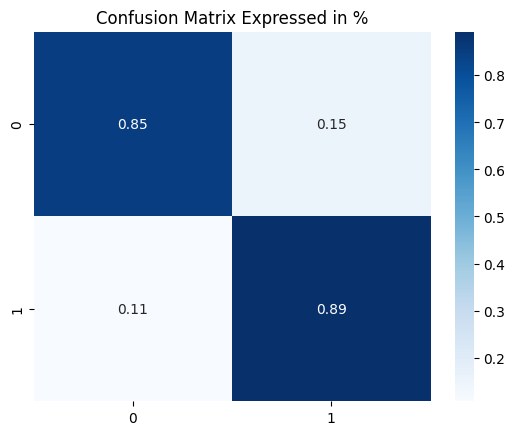

In [62]:
printModelStats(best_model_2, X_val, y_val)


## With glove embedding

In [63]:

from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

embedding_matrix = np.zeros((vocab_size, output_dimension))

for word, i in tokenizer.word_index.items():
     
    #trying to find word in glove model
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]



In [64]:
output_dimension = 100
def buildModel3(hp):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = output_dimension, input_length = max_length, weights=[embedding_matrix]))
    model.add((GRU(hp.Choice('units1', [32,64,128]))))
    model.add(Dropout(hp.Choice('rate1', [0.3,0.5, 0.7])))
    model.add(Dense(hp.Choice('units2', [8, 16, 32]), activation = "relu"))
    model.add(Dropout(hp.Choice('rate2', [0.3,0.5, 0.7])))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [65]:
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # The performance measure to monitor
    patience=2,  # How many epochs to wait after the last time the monitored quantity improved
    verbose=1,  # To log when training is being stopped
    mode='min',  # The direction is better when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [66]:
tuner = kt.RandomSearch(buildModel3, objective= 'val_loss', seed = 8, max_trials=10, directory= 'C:/projects', project_name = 'model_GRU_original_3')
tuner.search(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_val, y_val), callbacks = [early_stopping])

Trial 10 Complete [00h 01m 11s]
val_loss: 0.31162723898887634

Best val_loss So Far: 0.2956729233264923
Total elapsed time: 00h 12m 07s


In [67]:
best_hp3 = tuner.get_best_hyperparameters()[0]
best_model_3 = tuner.hypermodel.build(best_hp3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2592800   
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2625201 (10.01 MB)
Trainable params: 262

In [68]:
history = best_model_3.fit(X_train, y_train, epochs = 20, batch_size = 64, validation_data=(X_val, y_val),callbacks = early_stopping)

Epoch 1/20


314/314 [==============================] - 10s 27ms/step - loss: 0.6162 - accuracy: 0.6211 - val_loss: 0.4194 - val_accuracy: 0.8092
Epoch 2/20
314/314 [==============================] - 8s 26ms/step - loss: 0.4268 - accuracy: 0.7855 - val_loss: 0.3275 - val_accuracy: 0.8550
Epoch 3/20
314/314 [==============================] - 8s 26ms/step - loss: 0.3378 - accuracy: 0.8443 - val_loss: 0.3354 - val_accuracy: 0.8417
Epoch 4/20
314/314 [==============================] - 8s 27ms/step - loss: 0.3141 - accuracy: 0.8549 - val_loss: 0.3290 - val_accuracy: 0.8606
Epoch 4: early stopping


C:\Users\Bodine Stubbé\AppData\Local\Temp\ipykernel_34452\2336864335.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


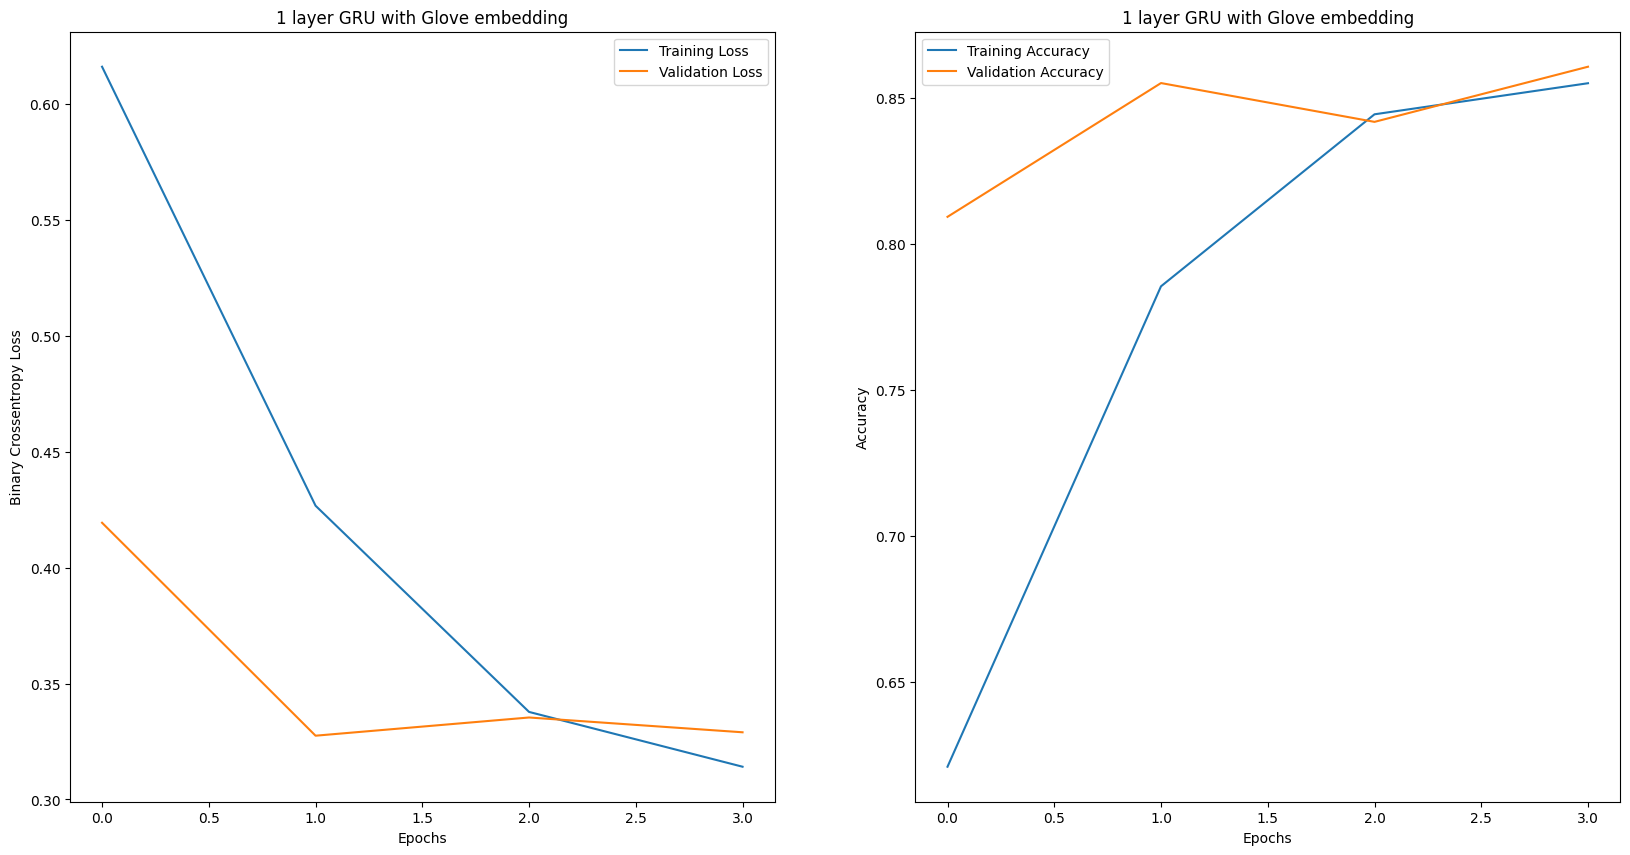

In [69]:
plotCurves(history, "1 layer GRU with Glove embedding")

90/90 [==============================] - 1s 3ms/step
               precision    recall  f1-score   support

    Sarcastic       0.88      0.83      0.86      1472
Not Sarcastic       0.83      0.88      0.85      1390

     accuracy                           0.85      2862
    macro avg       0.86      0.86      0.85      2862
 weighted avg       0.86      0.85      0.86      2862

The confusion matrix:
[[1226  246]
 [ 169 1221]]


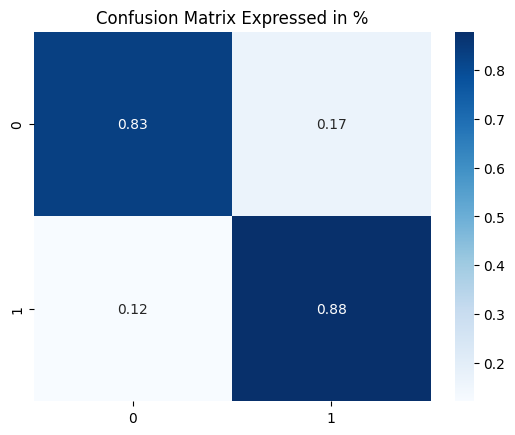

In [70]:
printModelStats(best_model_3, X_val, y_val)